In [103]:
#changing the working directory
%cd /content/drive/MyDrive/Kaggle/Forest-Cover-Type-Prediction/

/content/drive/MyDrive/Kaggle/Forest-Cover-Type-Prediction


In [ ]:
# unzipping your data
!unzip \*.zip  && rm *.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  test.csv.zip
  inflating: test.csv                

3 archives were successfully processed.


#Explore data

In [104]:
import pandas as pd

train_data_path = "train.csv"

forest_data = pd.read_csv(train_data_path)
forest_data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [105]:
forest_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


# In search of features

In [106]:
X = forest_data.copy()
y = X.pop("Cover_Type")

Compressing one-hot encoded soils to single column

In [107]:
soils_cols = [col for col in X if col.startswith('Soil')]
soils_df = forest_data[soils_cols]
soils_df

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15116,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15117,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15118,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [108]:
def get_soil(row):
  for c in soils_df.columns:
    if row[c]==1:
      return int(c.replace("Soil_Type", ""))

soils_series = soils_df.apply(get_soil, axis=1)

In [109]:
X['Soil_Type'] = soils_series
X = X.drop(soils_cols, axis=1)
X.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,29
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,29
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,12
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,30
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,29


Compressing one-hot encoded Wilderness Area to single column

In [110]:
area_cols = [col for col in X if col.startswith('Wilderness_Area')]
area_df = forest_data[area_cols]
area_df

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
15115,0,0,1,0
15116,0,0,1,0
15117,0,0,1,0
15118,0,0,1,0


In [111]:
def get_area(row):
  for c in area_df.columns:
    if row[c]==1:
      return int(c.replace("Wilderness_Area", ""))

area_series = area_df.apply(get_area, axis=1)

In [112]:
X['Wilderness_Area'] = area_series
X = X.drop(area_cols, axis=1)
X

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area
0,1,2596,51,3,258,0,510,221,232,148,6279,29,1
1,2,2590,56,2,212,-6,390,220,235,151,6225,29,1
2,3,2804,139,9,268,65,3180,234,238,135,6121,12,1
3,4,2785,155,18,242,118,3090,238,238,122,6211,30,1
4,5,2595,45,2,153,-1,391,220,234,150,6172,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,1282,4,3
15116,15117,2603,121,19,633,195,618,249,221,91,1325,4,3
15117,15118,2492,134,25,365,117,335,250,220,83,1187,4,3
15118,15119,2487,167,28,218,101,242,229,237,119,932,4,3


In [113]:
# drop Id column - not a feature

X = X.drop(columns=['Id'])
X

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area
0,2596,51,3,258,0,510,221,232,148,6279,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2607,243,23,258,7,660,170,251,214,1282,4,3
15116,2603,121,19,633,195,618,249,221,91,1325,4,3
15117,2492,134,25,365,117,335,250,220,83,1187,4,3
15118,2487,167,28,218,101,242,229,237,119,932,4,3


## Mutual Information

In [114]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)

In [115]:
mi_scores

Elevation                             0.798331
Soil_Type                             0.579698
Wilderness_Area                       0.509260
Horizontal_Distance_To_Roadways       0.230813
Horizontal_Distance_To_Fire_Points    0.168212
Hillshade_9am                         0.090274
Horizontal_Distance_To_Hydrology      0.075369
Slope                                 0.064723
Hillshade_3pm                         0.063215
Hillshade_Noon                        0.042290
Aspect                                0.025632
Vertical_Distance_To_Hydrology        0.020701
Name: MI Scores, dtype: float64

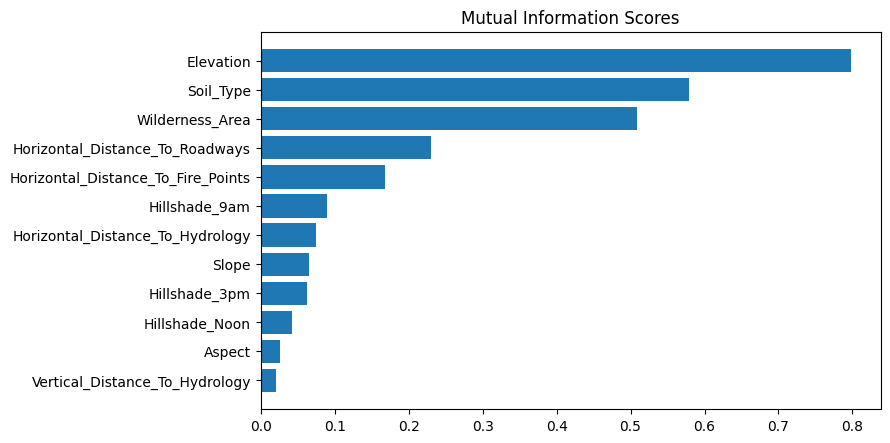

In [116]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Principal Component Analysis

In [117]:
from sklearn.decomposition import PCA

X_scaled_pca = (X - X.mean(axis=0)) / X.std(axis=0)

pca = PCA()
X_pca = pca.fit_transform(X_scaled_pca)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,2.477160,0.887175,-1.660365,0.190422,2.349859,3.298139,-0.042280,-0.859347,0.150063,-0.027898,0.851905,0.062460
1,2.443291,0.750880,-1.910634,0.203066,2.264236,3.342311,-0.078044,-0.860535,0.220926,-0.112753,0.827386,0.096655
2,2.788295,0.738386,-0.842181,-0.032486,3.583020,1.160188,-0.717273,-0.123105,0.131628,-0.188991,-0.034981,0.004964
3,3.022746,1.156629,0.205505,0.485688,3.116338,0.988679,-1.210236,-0.488893,1.057539,-0.550648,0.888736,-0.010663
4,2.358213,0.825166,-1.997278,0.289196,2.230608,3.306477,-0.030575,-0.805695,0.370424,-0.308822,0.762260,0.096627


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8c29340d0>,
      dtype=object)

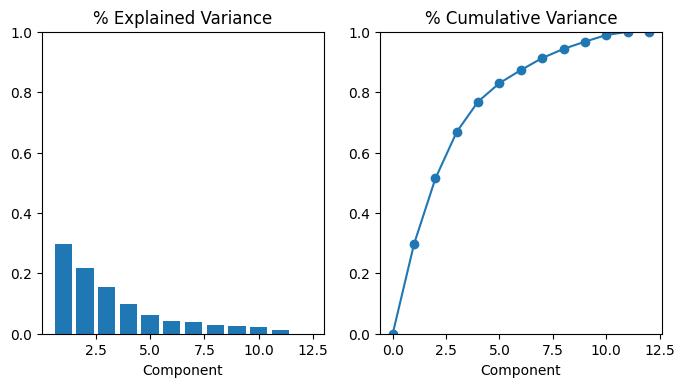

In [118]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

In [ ]:
make_mi_scores(X_pca, y)

PC1     0.650581
PC5     0.230388
PC8     0.179602
PC6     0.163122
PC11    0.134862
PC2     0.132624
PC7     0.068160
PC3     0.057066
PC4     0.056425
PC9     0.048328
PC10    0.023670
PC12    0.013427
Name: MI Scores, dtype: float64

In [119]:
X["PC1"] = X_pca.PC1
X["PC5"] = X_pca.PC5

make_mi_scores(X, y)

Elevation                             1.019658
Soil_Type                             0.906822
PC1                                   0.650581
Wilderness_Area                       0.504171
Horizontal_Distance_To_Roadways       0.315376
PC5                                   0.230388
Horizontal_Distance_To_Fire_Points    0.202159
Horizontal_Distance_To_Hydrology      0.122255
Hillshade_9am                         0.121433
Vertical_Distance_To_Hydrology        0.085458
Aspect                                0.081059
Hillshade_3pm                         0.073085
Slope                                 0.072595
Hillshade_Noon                        0.043649
Name: MI Scores, dtype: float64

In [ ]:
X_smaller = X.drop(["Vertical_Distance_To_Hydrology", "Aspect", "Slope", "Hillshade_3pm", "Hillshade_Noon"], axis=1)
make_mi_scores(X_smaller, y)

Elevation                             1.010298
Soil_Type                             0.917262
PC1                                   0.650581
Wilderness_Area                       0.518579
Horizontal_Distance_To_Roadways       0.317221
PC5                                   0.230388
Horizontal_Distance_To_Fire_Points    0.203458
Horizontal_Distance_To_Hydrology      0.120295
Hillshade_9am                         0.111522
Name: MI Scores, dtype: float64

In [120]:
X = X_smaller
X.head()

,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area,PC1,PC5
0,2596,258,510,221,6279,29,1,2.477160,2.349859
1,2590,212,390,220,6225,29,1,2.443291,2.264236
2,2804,268,3180,234,6121,12,1,2.788295,3.583020
3,2785,242,3090,238,6211,30,1,3.022746,3.116338
4,2595,153,391,220,6172,29,1,2.358213,2.230608


# Let the prediction begin

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
import itertools

Processing the actual submission test set

In [123]:
test_data_path = "test.csv"
test_set = pd.read_csv(test_data_path)
test_set

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565887,581008,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565888,581009,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565889,581010,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565890,581011,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
# compressing soils data
test_soils_cols = [col for col in test_set if col.startswith('Soil')]
test_soils_df = test_set[test_soils_cols]
test_soils_series = test_soils_df.apply(get_soil, axis=1)
test_set['Soil_Type'] = test_soils_series
test_set = test_set.drop(soils_cols, axis=1)

# compressing area data
test_area_cols = [col for col in test_set if col.startswith('Wilderness_Area')]
test_area_df = test_set[test_area_cols]
test_area_series = test_area_df.apply(get_area, axis=1)
test_set['Wilderness_Area'] = test_area_series
test_set = test_set.drop(test_area_cols, axis=1)

# extract & drop IDs
test_ids = test_set['Id']
test_set = test_set.drop(columns=['Id'])
test_set

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area
0,2680,354,14,0,0,2684,196,214,156,6645,29,1
1,2683,0,13,0,0,2654,201,216,152,6675,29,1
2,2713,16,15,0,0,2980,206,208,137,6344,29,1
3,2709,24,17,0,0,2950,208,201,125,6374,29,1
4,2706,29,19,0,0,2920,210,195,115,6404,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
565887,2396,153,20,85,17,108,240,237,118,837,2,3
565888,2391,152,19,67,12,95,240,237,119,845,2,3
565889,2386,159,17,60,7,90,236,241,130,854,2,3
565890,2384,170,15,60,5,90,230,245,143,864,2,3


In [125]:
test_set_scaled = (test_set- test_set.mean(axis=0)) / test_set.std(axis=0)

test_pca = PCA()
test_set_pca = test_pca.fit_transform(test_set_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(test_set_pca.shape[1])]
test_set_pca = pd.DataFrame(test_set_pca, columns=component_names)

test_set_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.581266,-0.864054,-1.544182,2.764314,1.445021,2.240141,0.094438,-1.023935,0.463173,1.109166,0.340615,-0.051950
1,-1.585880,0.530707,-1.426554,2.152867,1.647809,2.127987,0.685337,0.900630,-0.954223,0.379107,0.625269,-0.034215
2,-1.619453,0.908272,-1.157169,2.384192,1.448532,1.788730,0.680148,0.642317,-0.702917,0.410594,0.521431,-0.050262
3,-1.579659,1.283269,-0.954089,2.641720,1.407863,1.783686,0.667131,0.464571,-0.544974,0.420164,0.480693,-0.035447
4,-1.540727,1.618834,-0.769266,2.874062,1.373304,1.779237,0.661177,0.305413,-0.430376,0.404133,0.455298,-0.039503
...,...,...,...,...,...,...,...,...,...,...,...,...
565887,2.130164,2.207965,-1.968800,-1.272062,0.702718,-0.330336,-0.355606,-1.114229,-0.356698,-0.559007,0.220850,-0.039857
565888,2.089216,2.195967,-2.111233,-1.294967,0.663545,-0.301770,-0.343637,-1.053181,-0.327439,-0.499397,0.198084,-0.040712
565889,2.121597,1.839734,-2.351531,-1.413471,0.670026,-0.241129,-0.345634,-0.889237,-0.332154,-0.455673,0.205717,-0.046412
565890,2.205713,1.402388,-2.546812,-1.515780,0.701379,-0.176226,-0.362056,-0.698095,-0.336970,-0.402594,0.197159,-0.044162


In [126]:
test_set["PC1"] = test_set_pca["PC1"]
test_set["PC5"] = test_set_pca["PC5"]
test_set = test_set.drop(["Vertical_Distance_To_Hydrology", "Aspect", "Slope", "Hillshade_3pm", "Hillshade_Noon"], axis=1)
test_set

,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area,PC1,PC5
0,2680,0,2684,196,6645,29,1,-0.581266,1.445021
1,2683,0,2654,201,6675,29,1,-1.585880,1.647809
2,2713,0,2980,206,6344,29,1,-1.619453,1.448532
3,2709,0,2950,208,6374,29,1,-1.579659,1.407863
4,2706,0,2920,210,6404,29,1,-1.540727,1.373304
...,...,...,...,...,...,...,...,...,...
565887,2396,85,108,240,837,2,3,2.130164,0.702718
565888,2391,67,95,240,845,2,3,2.089216,0.663545
565889,2386,60,90,236,854,2,3,2.121597,0.670026
565890,2384,60,90,230,864,2,3,2.205713,0.701379


# Random Forest Classifier

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)

In [139]:
model_random_forest = RandomForestClassifier(n_estimators=1000, random_state=0)

In [129]:
scores = cross_val_score(model_random_forest, X_train, y_train, scoring='accuracy', cv=5, verbose=2)
print(scores.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  20.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


[CV] ................................................. , total=  20.8s
[CV]  ................................................................
[CV] ................................................. , total=  20.8s
[CV]  ................................................................
[CV] ................................................. , total=  20.9s
[CV]  ................................................................
[CV] ................................................. , total=  20.9s
0.8653273499396992


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [141]:
model_random_forest.fit(X_train, y_train)
pred_random_forest = model_random_forest.predict(X_test)

# XGBoost

Scaling data for model

In [131]:
pipeline_xgb = Pipeline(
    steps=[("scale", StandardScaler())]
)
num_cols = X.select_dtypes(include="number").columns
num_cols

Index(['Elevation', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type', 'Wilderness_Area',
       'PC1', 'PC5'],
      dtype='object')

In [132]:
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", pipeline_xgb, num_cols)
    ]
)

X_processed = full_processor.fit_transform(X)
y_processed = y.values.reshape(-1, 1)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=0
)

In [134]:
model_XGB = XGBClassifier(n_estimators=1000, learning_rate=0.05)

In [135]:
scores = cross_val_score(model_XGB, X_train, y_train, scoring='accuracy', cv=5, verbose=2)
print(scores.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  ................................................................
[CV] ................................................. , total=  30.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s remaining:    0.0s


[CV] ................................................. , total=  30.8s
[CV]  ................................................................
[CV] ................................................. , total=  30.7s
[CV]  ................................................................
[CV] ................................................. , total=  30.8s
[CV]  ................................................................
[CV] ................................................. , total=  30.8s
0.8187830687830688


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [136]:
model_XGB.fit(X_train, y_train)
pred_XGB = model_XGB.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Testing model

Testing on a test set from training set

In [142]:
# insert appropriate predictions to y_pred
cm = confusion_matrix(y_true=y_test, y_pred=pred_random_forest)
accuracy_score(y_test, pred_random_forest)

0.8697089947089947

In [143]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(title)

Confusion matrix, without normalization
[[337  54   1   0  10   2  28]
 [ 76 294  14   0  32  15   1]
 [  0   1 356  17  11  47   0]
 [  0   0  11 416   0   5   0]
 [  0   3   6   0 418   5   0]
 [  0   0  35   9   4 384   0]
 [  7   0   0   0   0   0 425]]


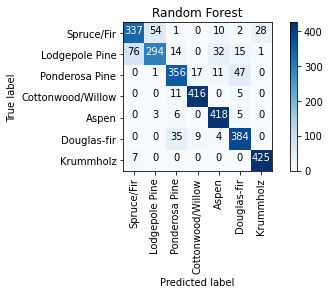

In [144]:
# Choose appropriate title for the plot
cm_plot_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Random Forest")

Testing on submission test set

In [ ]:
# insert appropriate model here
pred_submission = model_random_forest.predict(test_set)
pred_submission

array([2, 2, 2, ..., 3, 3, 3])

In [ ]:
submission_df = pd.DataFrame(
    {
        'Id': test_ids.values,
        'Cover_Type': pred_submission
    },
    columns=['Id', 'Cover_Type']
)
submission_df

,Id,Cover_Type
0,15121,2
1,15122,2
2,15123,2
3,15124,2
4,15125,2
...,...,...
565887,581008,3
565888,581009,3
565889,581010,3
565890,581011,3


In [ ]:
submission_df.to_csv('submission.csv', index=False)
